The aim of this notebook is to develop a model that predicts if a player will get a PER over per_threshold (15 in this case) in the first 5 seasons in the NBA, just using the NCAA stats of the last year and some physical features (it does not apply for international players who did not attend the NCAA).

In [1]:
import pandas as pd
import os
import numpy as np

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

In [27]:
# We define the minimum PER to consider a player with a positive label.
per_threshold = 15
# We define a seed for the whole experiment.
seed = 1

derived_data_folder = 'derived_data/'
original_data_folder = 'original_data/'

original_draft_data_folder = original_data_folder + 'drafts/'
derived_draft_data_folder = derived_data_folder + 'drafts/'

original_ncaa_data_folder = original_data_folder + 'ncaa/'
derived_ncaa_data_folder = derived_data_folder + 'ncaa/'

model_data = derived_data_folder + 'over_{}_per_model_data/'.format(per_threshold)

if not os.path.exists(model_data):
    os.mkdir(model_data)


In [28]:
def load_year_draft_data(year):
    return pd.read_csv(derived_draft_data_folder + 'draft_{}.csv'.format(year))

def load_all_draft_data():
    return pd.concat([load_year_draft_data(year) for year in range(2003, 2014)], ignore_index=True)

def aux_load_advanced_stats_nba_data(path, year):
    df = pd.read_csv(path)
    df['year'] = year
    return df
    
def load_advanced_stats_nba_data():
    years = sorted([int(f.split('_')[1]) for f in os.listdir(original_data_folder) if f.startswith('season')])
    return pd.concat([aux_load_advanced_stats_nba_data(original_data_folder + 'season_{}/{}_{}_advanced_player_season_totals.csv'.format(year, year-1, year), year) 
                      for year in years], 
                     ignore_index=True).reset_index(drop=True)

def feet_to_cm(ht):
    ht = ht.split('-')
    h_ft, h_inch = int(ht[0]), int(ht[1])
    h_inch += h_ft * 12
    h_cm = round(h_inch * 2.54, 1)
    return h_cm

def lbs_to_kg(lbs):
    return lbs * 0.453592

# dictionary to unify class names numerically.
class_converter_dic = {'Fr *': 1, 'Fr': 1, 
                       'So *': 2, 'So': 2, 
                       'Jr *': 3, 'Jr': 3,
                       'Sr *': 4, 'Sr': 4}

# dictionary to convert position names in draft data into lists of all played positions.
pos_converter_dic = {'G': ['PG', 'SG'], 
                     'F': ['SF', 'PF'],
                     'PF': ['PF'],
                     'SG': ['SG'],
                     'SF': ['SF'],
                     'GF': ['SG', 'SF'],
                     'C': ['C'],
                     'PG': ['PG'],
                     'FC': ['PF', 'C'],
                     'F-G': ['SG', 'SF'],
                     'G-F': ['SG', 'SF']}

In [29]:
draft_data = load_all_draft_data()
# In this case, there are four rows with repeated names of players, with only one of them entering the NBA draft.
# I manually drop the ones that do not correspond.
draft_data = draft_data.drop([94,147, 374, 483])
draft_data = draft_data[draft_data['class'].map(lambda x: any([key == x for key in class_converter_dic.keys()]))]
# We drop players from the draft who were not on the top 2000 of the scraped statistics. This includes not NCAA players.
draft_data = draft_data[pd.notna(draft_data.mpg)].reset_index(drop=True)

draft_data['ht'] = draft_data['ht'].map(feet_to_cm)
draft_data['wt'] = draft_data['wt'].map(lbs_to_kg)

draft_data['pos_pg'] = draft_data.pos.map(lambda x: 'PG' in pos_converter_dic[x]).astype(int)
draft_data['pos_sg'] = draft_data.pos.map(lambda x: 'SG' in pos_converter_dic[x]).astype(int)
draft_data['pos_sf'] = draft_data.pos.map(lambda x: 'SF' in pos_converter_dic[x]).astype(int)
draft_data['pos_pf'] = draft_data.pos.map(lambda x: 'PF' in pos_converter_dic[x]).astype(int)
draft_data['pos_c'] = draft_data.pos.map(lambda x: 'C' in pos_converter_dic[x]).astype(int)

draft_data['class'] =  draft_data['class'].map(lambda x: class_converter_dic[x])

draft_data.to_csv(model_data + 'cleaned_data.csv', index=False)
draft_data

,pick,player,team_nba,draft trades,pos,ht,wt,age,yos,pre-draft team,class,nationality,#_averages,team_ncaa,gp_averages,mpg,fgm_averages,fga_averages,fg%_averages,3pm_averages,3pa_averages,3p%_averages,ftm_averages,fta_averages,ft%_averages,tov_averages,pf_averages,orb_averages,drb_averages,rpg,apg,spg,bpg,ppg,#_totals,gp_totals,min_totals,fgm_totals,fga_totals,fg%_totals,3pm_totals,3pa_totals,3p%_totals,ftm_totals,fta_totals,ft%_totals,tov_totals,pf_totals,orb_totals,drb_totals,...,pts_per_48,#_misc_stats,dbl dbl,tpl dbl,40 pts,20 reb,20 ast,5 stl,5 blk,high game,techs,hob,ast/to,stl/to,ft/fga,w's,l's,win %,ows,dws,ws,#,ts%,efg%,total s %,orb%,drb%,trb%,ast%,tov%,stl%,blk%,usg%,ppr,pps,ortg,drtg,ediff,fic,per,year,appearances,years,notes,first_time,pos_pg,pos_sg,pos_sf,pos_pf,pos_c
0,3,Carmelo Anthony,DEN,NaN,F,203.2,108.862080,19,17,Syracuse,1,United States,40.0,SU,35.0,36.4,7.9,17.5,0.453,1.6,4.7,0.337,4.8,6.8,0.706,2.2,2.2,2.9,6.9,9.7,2.2,1.5,0.9,22.2,1.0,35.0,1274.0,277.0,612.0,0.453,56.0,166.0,0.337,168.0,238.0,0.706,77.0,77.0,101.0,240.0,...,29.3,108.0,21.0,0.0,0.0,0.0,0.0,0.0,0.0,33.0,2.0,0.347,1.0,0.7,0.4,30.0,5.0,0.857,4.8,2.8,7.6,207.0,0.537,0.498,149.6,9.5,19.5,14.8,11.9,9.6,2.2,2.3,29.3,-1.9,1.3,116.8,92.5,24.3,554.2,25.0,2003.0,10.0,"[2007, 2008, 2010, 2011, 2012, 2013, 2014, 201...",NaN,2007.0,0,0,1,1,0
1,4,Chris Bosh,TOR,NaN,PF,210.8,106.594120,19,14,Georgia Tech,1,United States,534.0,GT,31.0,31.0,5.5,9.7,0.560,0.7,1.5,0.468,4.1,5.6,0.730,2.3,2.4,3.1,5.9,9.0,1.2,1.0,2.1,15.7,339.0,31.0,960.0,169.0,302.0,0.560,22.0,47.0,0.468,127.0,174.0,0.730,72.0,73.0,95.0,183.0,...,24.4,475.0,13.0,0.0,0.0,0.0,0.0,0.0,2.0,26.0,0.0,0.248,0.5,0.4,0.6,16.0,15.0,0.516,3.3,2.0,5.3,1081.0,0.633,0.596,175.8,11.6,22.3,16.9,7.9,15.8,1.7,6.8,22.4,-4.6,1.6,120.7,93.5,27.2,453.0,24.7,2003.0,11.0,"[2006, 2007, 2008, 2009, 2010, 2011, 2012, 201...",Missed 2009[51] and 2016[52] games,2006.0,0,0,0,1,0
2,5,Dwyane Wade,MIA,NaN,SG,193.0,99.790240,21,16,Marquette,3,United States,408.0,MU,33.0,32.1,7.6,15.2,0.501,0.4,1.3,0.318,5.9,7.5,0.779,3.2,2.3,1.8,4.5,6.3,4.4,2.2,1.3,21.5,108.0,33.0,1058.0,251.0,501.0,0.501,14.0,44.0,0.318,194.0,249.0,0.779,107.0,76.0,60.0,149.0,...,32.2,73.0,5.0,1.0,0.0,0.0,0.0,2.0,0.0,35.0,0.0,0.440,1.4,0.7,0.5,27.0,6.0,0.818,5.3,1.9,7.2,65.0,0.573,0.515,159.8,7.2,15.4,11.6,31.1,14.7,4.0,4.2,34.4,-1.0,1.4,118.8,96.3,22.5,526.6,31.3,2003.0,13.0,"[2005, 2006, 2007, 2008, 2009, 2010, 2011, 201...",Missed 2015[12] game,2005.0,0,1,0,0,0
3,6,Chris Kaman,LAC,NaN,C,213.4,120.201880,21,13,Central Michigan,3,United States / Germany,187.0,CMU,31.0,34.0,7.9,12.6,0.622,0.0,0.0,0.000,6.7,8.9,0.750,4.4,3.2,3.6,8.4,12.0,1.3,0.6,3.2,22.4,111.0,31.0,1055.0,244.0,392.0,0.622,0.0,0.0,0.000,207.0,276.0,0.750,137.0,99.0,112.0,261.0,...,31.6,14.0,25.0,0.0,1.0,2.0,0.0,0.0,9.0,43.0,0.0,0.344,0.3,0.1,0.7,24.0,7.0,0.774,4.2,2.1,6.2,171.0,0.664,0.622,137.2,14.4,28.6,22.1,8.6,20.8,1.0,8.5,30.2,-10.0,1.8,116.2,94.8,21.4,574.8,29.0,2003.0,1.0,[2010],NaN,2010.0,0,0,0,0,1
4,7,Kirk Hinrich,CHI,NaN,G,193.0,86.182480,22,13,Kansas,4,United States,235.0,KU,37.0,33.5,6.3,13.2,0.475,2.4,5.9,0.406,2.4,3.4,0.704,2.2,2.1,1.0,2.7,3.8,3.5,1.9,0.4,17.3,7.0,37.0,1241.0,232.0,488.0,0.475,89.0,219.0,0.406,88.0,125.0,0.704,83.0,78.0,38.0,101.0,...,24.8,261.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,29.0,0.0,0.316,1.6,0.8,0.3,29.0,8.0,0.784,4.2,2.7,6.9,966.0,0.586,0.567,158.6,3.4,8.6,6.1,17.9,13.2,3.1,1.2,22.9,0.3,1.3,119.8,92.7,27.1,434.9,21.1,2003.0,NaN,NaN,NaN,NaN,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421,51,Romero Osby,ORL,NaN,PF,203.2,108.862080,23,0,Oklahoma,4,United States,902.0,OU,32.0,28.4,5.4,10.3,0.526,0

In [30]:
advanced_stats_nba = load_advanced_stats_nba_data()

In [31]:
# We compute the labels
draft_data['per_over_{}'.format(per_threshold)] = 0
for index, row in draft_data.iterrows():
    draft_year = row.year
    df = advanced_stats_nba[advanced_stats_nba.name == row.player]
    df = df[df.year.between(draft_year+1, draft_year+5)]
    df = df[df.games_played > 20]
    df = df[df.player_efficiency_rating >= per_threshold]
    if df.shape[0]:
        draft_data.at[index, 'per_over_{}'.format(per_threshold)] = 1

In [39]:
draft_data.to_csv(model_data + 'cleaned_data.csv', index=False)

### Eliminar columnas y preparar variables para el modelo

In [40]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, auc, precision_recall_curve, roc_curve, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
import seaborn as sns 
import matplotlib.pyplot as plt


In [57]:
draft_data = pd.read_csv(model_data + 'cleaned_data.csv')

# We select the columns to drop from the table to avoid entering the model information which is not available 
# when the draft occurs.
columns_to_drop = ['pick'] + draft_data.select_dtypes(include='object').columns.tolist()
columns_to_drop += [col for col in draft_data.columns if '#' in col]
columns_to_drop += ['appearances', 'year', '20 ast', 'yos', 'first_time']

draft_data = draft_data.drop(columns=columns_to_drop)

# We shuffle the data and split the data into train and test.
draft_data = draft_data.sample(frac=1, random_state=seed).reset_index(drop=True)
num_samples = draft_data.shape[0]
train_draft_data = draft_data.iloc[:int(num_samples*0.8)]
test_draft_data = draft_data.iloc[int(num_samples*0.8):]

# We split the dataset into data and labels.
train_target = train_draft_data['per_over_{}'.format(per_threshold)].values
test_target = test_draft_data['per_over_{}'.format(per_threshold)].values
train_draft_data = train_draft_data.drop(columns=['per_over_{}'.format(per_threshold)])
test_draft_data = test_draft_data.drop(columns=['per_over_{}'.format(per_threshold)])

# Normalize the data using train values.
max_values = np.quantile(train_draft_data.values, 0.99, axis=0)
min_values = np.quantile(train_draft_data.values, 0.01, axis=0)
train_draft_data = (train_draft_data - min_values) / (max_values - min_values)
test_draft_data = (test_draft_data - min_values) / (max_values - min_values)

train_draft_data.to_csv(model_data + 'train_data.csv', index=False)
test_draft_data.to_csv(model_data + 'test_data.csv', index=False)

np.save(model_data + 'max_values.npy', max_values)
np.save(model_data + 'min_values.npy', min_values)

In [51]:
def compute_accuracy(objective, result):
    ''' 
    Computes accuracy comparing predictions with ground truth labels.
    '''
    return accuracy_score(objective, result)

def plot_roc_curve(objective, results_probs, dataset_name, generate_plot=True, show_plot=True, save_path=None):
    '''
    Get the plot for the ROC curve against the baseline score.
    '''
    fpr, tpr, thresholds = roc_curve(objective, results_probs)
    auroc = auc(fpr, tpr)
    
    auprc_random = 0.5
    
    if generate_plot:
        plt.figure(figsize=(8,8))
        sns.set()
        lw = 2
        sns.lineplot(fpr, tpr, color='darkorange', lw=lw, ci=None, estimator='max', 
                     label='AUROC curve (area = %0.2f)' % auroc)
        plt.plot([0.0, 1.0], [0.0, 1.0], color='navy', linestyle='--', lw=lw, 
                 label='random AUROC curve (area = %0.2f)' % auprc_random)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])
        plt.xlabel('1 - Specificity', fontsize=18)
        plt.ylabel('Sensitivity', fontsize=18)
        plt.title('Roc curve - ' + dataset_name, fontsize=18)
        plt.legend(loc="lower right", fontsize=18)
        if save_path is not None:
            splitted_path = save_path.split('/')
            output_path = '/'.join(splitted_path[:-1])
            if not os.path.exists(output_path):
                os.makedirs(output_path)
            plt.savefig(save_path)
        if not show_plot:
            plt.close(fig='all')
        
    return auroc, auprc_random

def plot_pr_curve(objective, results_probs, dataset_name, generate_plot=True, show_plot=True, save_path=None):
    '''
    Get the plot for the Precision-Recall curve against the baseline score.
    '''
    precision, recall, thresholds = precision_recall_curve(objective, results_probs)
    auprc = auc(recall, precision)

    precision_random, recall_random, thresholds_random = precision_recall_curve(objective, np.random.rand(len(objective)))
    auprc_random = auc(recall_random, precision_random)
    
    if generate_plot:
        plt.figure(figsize=(8,8))
        sns.set()
        lw = 2
        sns.lineplot(recall, precision, color='darkorange', lw=lw, ci=None, estimator='max', 
                     label='AUPRC curve (area = %0.2f)' % auprc)
        plt.plot([0, 1], [auprc_random, auprc_random], color='navy', linestyle='--', lw=lw, 
                 label='random AUPRC curve (area = %0.2f)' % auprc_random)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])
        plt.xlabel('Recall', fontsize=18)
        plt.ylabel('Precision', fontsize=18)
        plt.title('Precision-Recall curve - ' + dataset_name, fontsize=18)
        plt.legend(loc="lower right", fontsize=18)
        if save_path is not None:
            splitted_path = save_path.split('/')
            output_path = '/'.join(splitted_path[:-1])
            if not os.path.exists(output_path):
                os.makedirs(output_path)
            plt.savefig(save_path)
        if not show_plot:
            plt.close(fig='all')
        
    return auprc, auprc_random


C:\anaconda3\envs\recreativo2\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\anaconda3\envs\recreativo2\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\anaconda3\envs\recreativo2\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\anacond

(0.7159090909090909, 0.5)

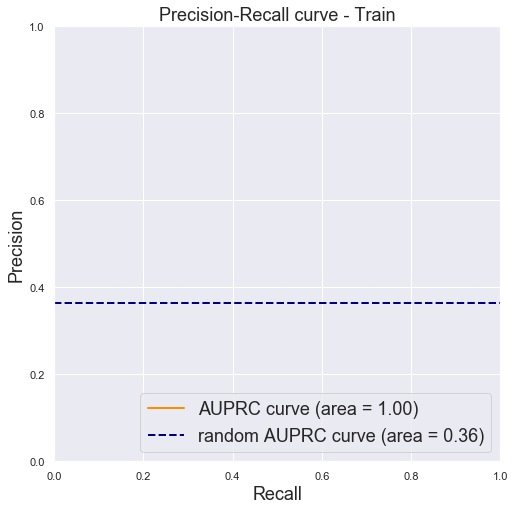

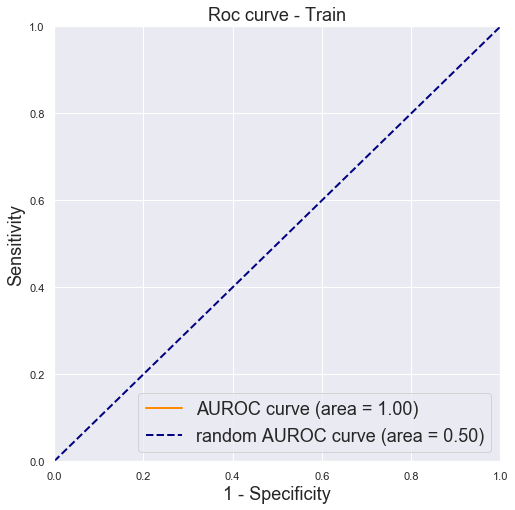

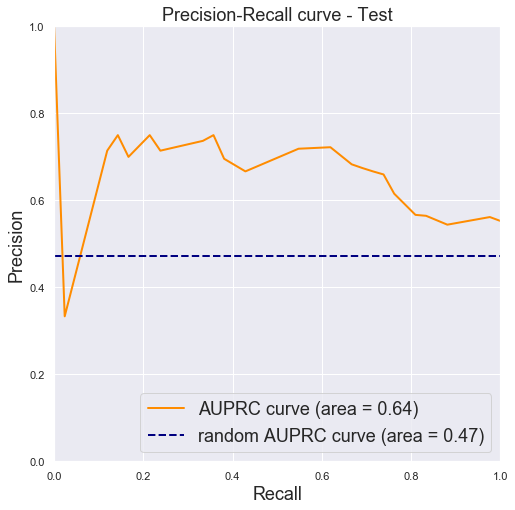

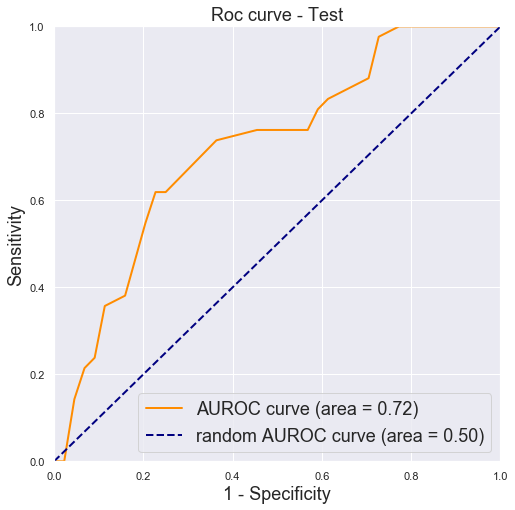

In [52]:
# First training without fine tuning and curves:
rf = RandomForestClassifier(n_estimators=50, random_state=seed)
rf.fit(train_draft_data, train_target)

train_probs = rf.predict_proba(train_draft_data)[:,1]
test_probs = rf.predict_proba(test_draft_data)[:,1]

plot_pr_curve(train_target, train_probs, 'Train')
plot_roc_curve(train_target, train_probs, 'Train')

plot_pr_curve(test_target, test_probs, 'Test')
plot_roc_curve(test_target, test_probs, 'Test')


### Pipeline de predicción

In [53]:
def predict_dataset(set_type, model):
    '''
    Predict labels of a split (train or test) using a given model.
    '''
    draft_data = pd.read_csv(model_data + 'cleaned_data.csv')
    draft_data = draft_data.sample(frac=1, random_state=seed).reset_index(drop=True)

    pipeline_data = draft_data.copy()
    pipeline_data = pipeline_data.drop(columns=columns_to_drop + ['per_over_{}'.format(per_threshold)])

    num_samples = draft_data.shape[0]
    draft_data['set'] = draft_data.index.map(lambda x: 'train' if x < int(num_samples*0.8) else 'test')

    max_values = np.load(model_data + 'max_values.npy')
    min_values = np.load(model_data + 'min_values.npy')
    pipeline_data = (pipeline_data - min_values) / (max_values - min_values)

    draft_data['prediction'] = model.predict_proba(pipeline_data)[:,1]
    return draft_data[draft_data['set'] == set_type].sort_values('prediction', ascending=False)

Using Cross Validation and a Random Search, get the optimum hyperparameters of the Random Forest.

In [54]:
# Number of trees in Random Forest
rf_n_estimators = [int(x) for x in np.linspace(200, 1000, 5)]
rf_n_estimators.append(1500)
rf_n_estimators.append(2000)

# Maximum number of levels in tree
rf_max_depth = [int(x) for x in np.linspace(5, 55, 11)]
# Add the default as a possible value
rf_max_depth.append(None)

# Number of features to consider at every split
rf_max_features = ['auto', 'sqrt', 'log2']

# Criterion to split on
rf_criterion = ['gini', 'entropy']

# Minimum number of samples required to split a node
rf_min_samples_split = [int(x) for x in np.linspace(2, 10, 9)]

# Minimum decrease in impurity required for split to happen
rf_min_impurity_decrease = [0.0, 0.05, 0.1]

# Method of selecting samples for training each tree
rf_bootstrap = [True, False]

# Create the grid
rf_grid = {'n_estimators': rf_n_estimators,
               'max_depth': rf_max_depth,
               'max_features': rf_max_features,
               'criterion': rf_criterion,
               'min_samples_split': rf_min_samples_split,
               'min_impurity_decrease': rf_min_impurity_decrease,
               'bootstrap': rf_bootstrap}

rf_base = RandomForestClassifier()

# Create the random search Random Forest
rf_random = RandomizedSearchCV(estimator = rf_base, param_distributions = rf_grid, 
                               n_iter = 200, cv = 3, verbose = 2, random_state = seed, 
                               n_jobs = -1)

# Fit the random search model
rf_random.fit(np.concatenate([train_draft_data, test_draft_data]), 
              np.concatenate([train_target, test_target]))

# View the best parameters from the random search
rf_random.best_params_

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   21.6s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  6.4min finished
C:\Users\José María VL\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'n_estimators': 1500,
 'min_samples_split': 7,
 'min_impurity_decrease': 0.0,
 'max_features': 'auto',
 'max_depth': 20,
 'criterion': 'gini',
 'bootstrap': True}

C:\anaconda3\envs\recreativo2\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\anaconda3\envs\recreativo2\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\anaconda3\envs\recreativo2\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\anacond

(0.7072510822510822, 0.5)

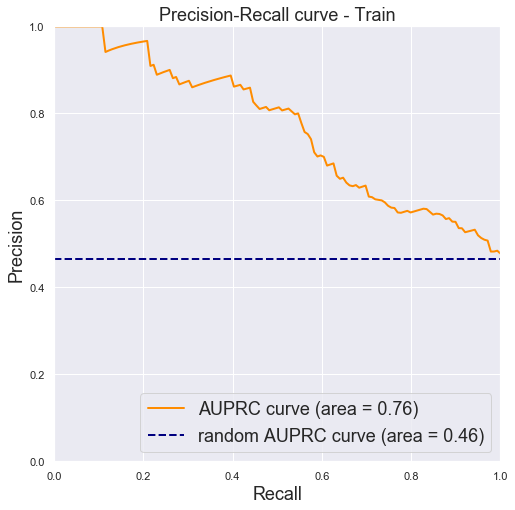

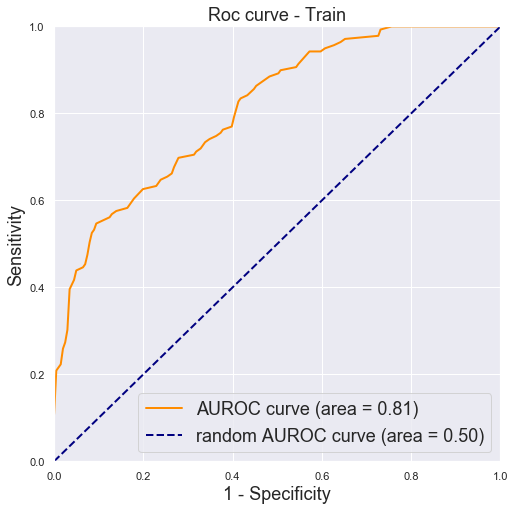

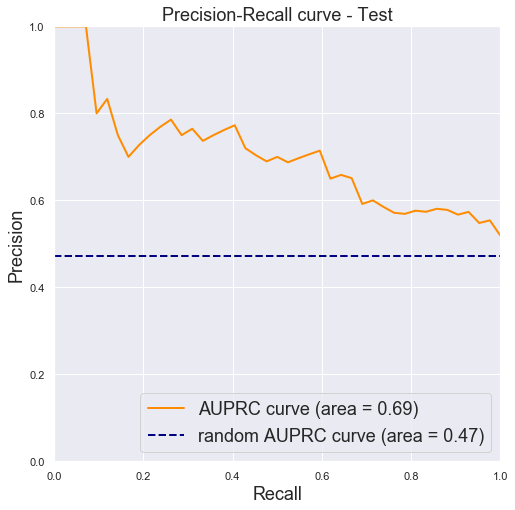

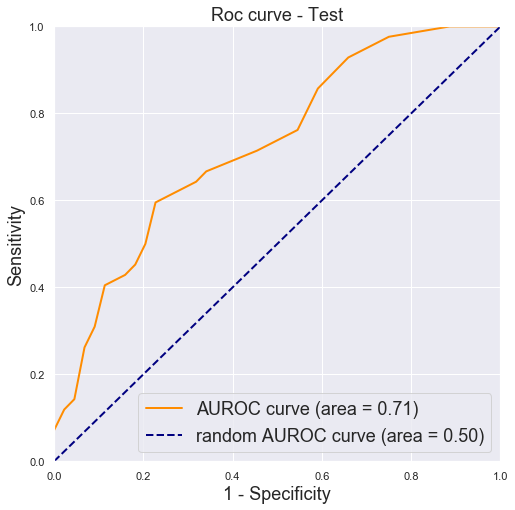

In [55]:
hps_dic = {'n_estimators': 600,
            'min_samples_split': 5,
            'min_impurity_decrease': 0.05,
            'max_features': 'log2',
            'max_depth': 25,
            'criterion': 'gini',
            'bootstrap': True}

rf = RandomForestClassifier(n_estimators=hps_dic['n_estimators'], 
                            min_samples_split=hps_dic['min_samples_split'],
                            min_impurity_decrease=hps_dic['min_impurity_decrease'],
                            max_features=hps_dic['max_features'],
                            max_depth=hps_dic['max_depth'],
                            criterion=hps_dic['criterion'],
                            bootstrap=hps_dic['bootstrap'],
                            random_state=seed)
rf.fit(train_draft_data, train_target)

train_probs = rf.predict_proba(train_draft_data)[:,1]
test_probs = rf.predict_proba(test_draft_data)[:,1]

plot_pr_curve(train_target, train_probs, 'Train')
plot_roc_curve(train_target, train_probs, 'Train')

plot_pr_curve(test_target, test_probs, 'Test')
plot_roc_curve(test_target, test_probs, 'Test')


In [56]:
predict_dataset('test', rf)

,pick,player,team_nba,draft trades,pos,ht,wt,age,yos,pre-draft team,class,nationality,#_averages,team_ncaa,gp_averages,mpg,fgm_averages,fga_averages,fg%_averages,3pm_averages,3pa_averages,3p%_averages,ftm_averages,fta_averages,ft%_averages,tov_averages,pf_averages,orb_averages,drb_averages,rpg,apg,spg,bpg,ppg,#_totals,gp_totals,min_totals,fgm_totals,fga_totals,fg%_totals,3pm_totals,3pa_totals,3p%_totals,ftm_totals,fta_totals,ft%_totals,tov_totals,pf_totals,orb_totals,drb_totals,...,tpl dbl,40 pts,20 reb,20 ast,5 stl,5 blk,high game,techs,hob,ast/to,stl/to,ft/fga,w's,l's,win %,ows,dws,ws,#,ts%,efg%,total s %,orb%,drb%,trb%,ast%,tov%,stl%,blk%,usg%,ppr,pps,ortg,drtg,ediff,fic,per,year,appearances,years,notes,first_time,pos_pg,pos_sg,pos_sf,pos_pf,pos_c,per_over_15,set,prediction
415,47,Paul Millsap,UTH,NaN,FC,200.7,116.573144,21,14,Louisiana Tech,3,United States,178.0,LTU,33.0,34.1,7.8,13.7,0.571,0.2,0.4,0.357,3.8,6.2,0.626,2.5,3.1,5.9,7.2,13.2,1.1,1.9,2.3,19.6,60.0,33.0,1126.0,258.0,452.0,0.571,5.0,14.0,0.357,127.0,203.0,0.626,81.0,101.0,196.0,239.0,...,0.0,0.0,2.0,0.0,2.0,4.0,29.0,1.0,0.359,0.4,0.8,0.4,20.0,13.0,0.606,4.4,3.5,7.9,362.0,0.591,0.576,155.4,17.6,23.0,20.2,8.0,12.9,3.4,7.0,27.1,-5.2,1.4,118.8,83.8,35.0,649.6,32.3,2006.0,4.0,"[2014, 2015, 2016, 2017]",NaN,2014.0,0,0,0,1,1,1,test,0.474967
379,2,Emeka Okafor,CHA,NaN,FC,208.3,115.665960,21,11,Connecticut,3,United States,314.0,UConn,36.0,32.4,7.2,12.1,0.599,0.0,0.0,0.000,3.1,6.1,0.518,2.3,2.4,3.8,7.7,11.5,1.0,1.0,4.1,17.6,14.0,36.0,1166.0,261.0,436.0,0.599,0.0,0.0,0.000,113.0,218.0,0.518,84.0,85.0,138.0,277.0,...,1.0,0.0,1.0,0.0,0.0,15.0,29.0,0.0,0.281,0.4,0.4,0.5,30.0,6.0,0.833,3.3,3.9,7.2,540.0,0.588,0.599,111.7,12.8,22.0,17.8,6.1,13.5,1.8,10.9,25.4,-4.9,1.5,115.5,83.6,31.9,663.5,28.5,2004.0,NaN,NaN,NaN,NaN,0,0,0,1,1,1,test,0.471127
386,13,Markieff Morris,PHX,NaN,PF,208.3,111.130040,21,9,Kansas,3,United States,1408.0,KU,38.0,24.4,5.1,8.7,0.589,0.7,1.6,0.424,2.7,4.0,0.682,2.1,2.8,2.7,5.6,8.3,1.4,0.8,1.1,13.6,736.0,38.0,926.0,195.0,331.0,0.589,25.0,59.0,0.424,103.0,151.0,0.682,78.0,108.0,103.0,213.0,...,0.0,0.0,0.0,0.0,0.0,0.0,26.0,0.0,0.222,0.7,0.4,0.5,35.0,3.0,0.921,3.6,2.6,6.2,560.0,0.643,0.627,169.5,13.7,25.0,19.7,10.8,16.2,1.9,4.9,25.5,-4.5,1.6,121.6,87.9,33.8,468.9,27.0,2011.0,NaN,NaN,NaN,NaN,0,0,0,1,0,1,test,0.467985
417,36,Jordan Williams,NJN,NaN,PF,208.3,117.933920,20,1,Maryland,2,United States,320.0,UMD,33.0,32.5,6.5,12.0,0.538,0.0,0.0,0.000,4.0,6.9,0.575,1.6,2.4,3.7,8.1,11.8,0.6,0.7,1.4,16.9,251.0,33.0,1073.0,213.0,396.0,0.538,0.0,0.0,0.000,131.0,228.0,0.575,53.0,80.0,121.0,267.0,...,0.0,0.0,0.0,0.0,0.0,1.0,27.0,0.0,0.251,0.4,0.4,0.6,19.0,14.0,0.576,3.1,2.8,5.9,697.0,0.552,0.538,111.2,12.5,26.1,19.5,3.9,9.5,1.2,4.1,24.6,-3.4,1.4,115.0,89.6,25.4,491.8,23.7,2011.0,NaN,NaN,NaN,NaN,0,0,0,1,0,0,test,0.460389
349,2,Kevin Durant,SEA,NaN,SF,208.3,108.862080,18,13,Texas,1,United States,70.0,UT,35.0,35.9,8.7,18.5,0.472,2.3,5.8,0.404,6.0,7.3,0.816,2.8,2.0,3.0,8.1,11.1,1.3,1.9,1.9,25.8,10.0,35.0,1255.0,306.0,648.0,0.472,82.0,203.0,0.404,209.0,256.0,0.816,99.0,71.0,106.0,284.0,...,0.0,0.0,1.0,0.0,1.0,3.0,37.0,1.0,0.366,0.5,0.7,0.4,25.0,10.0,0.714,5.8,2.9,8.7,71.0,0.587,0.535,169.3,9.0,24.0,16.5,8.6,11.4,3.0,5.5,33.2,-5.2,1.4,120.3,92.3,28.1,684.5,32.7,2007.0,11.0,"[2010, 2011, 2012, 2013, 2014, 2015, 2016, 201...",Missed 2021 game,2010.0,0,0,1,0,0,1,test,0.459784
402,13,Kelly Olynyk,DAL,DAL to BOS,C,213.4,108.862080,22,7,Gonzaga,3,Canada,1163.0,GU,32.0,26.4,6.7,10.7,0.629,0.3,0.9,0.300,4.1,5.3,0.776,2.4,2.2,2.4,4.9,7.3,1.7,0.7,1.1,17.8,1017.0,32.0,845.0,215.0,342.0,0.629,9.0,30.0,0.300,132.0,170.0,0.776,77.0,72.0,77.0,158.0,...,0.0,0.0,0.0,0.0,0.0,0.0,33.0,0.0,0.317,0.7,0.3,0.5,29.0,3.0,0.906,4.9,1.9,6.8,119.0,0.675,0.642,170.5,12.0,20.8,16.7,15.8,15.4,1.6,5.1,31.3,-4.9,1.7,127.1,90.2,36.9,446.2,34.3,2013.0,NaN,NaN,NaN,NaN,0,0,0,0,1,1,test,0.457352
376,1,Anthony Bennett,CLE,NaN,PF,203.2,111.130040,20,4,UNLV,1,Canada,1072.0,UNLV,35.0,27.1,5.8,10.8,0.533,1.0,2.7,0.375,3.5,5

Additionally, we make a simple try reducing dimensionality of input data with PCA, which does not really improve the score.

In [60]:
from sklearn.decomposition import PCA

pca = PCA(n_components=5)
pca_train_draft_data = pca.fit_transform(train_draft_data)
pca_test_draft_data = pca.transform(test_draft_data)

C:\anaconda3\envs\recreativo2\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\anaconda3\envs\recreativo2\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\anaconda3\envs\recreativo2\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\anacond

(0.7031926406926408, 0.5)

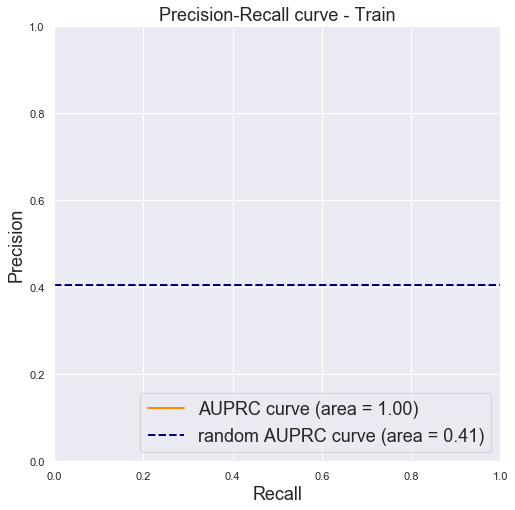

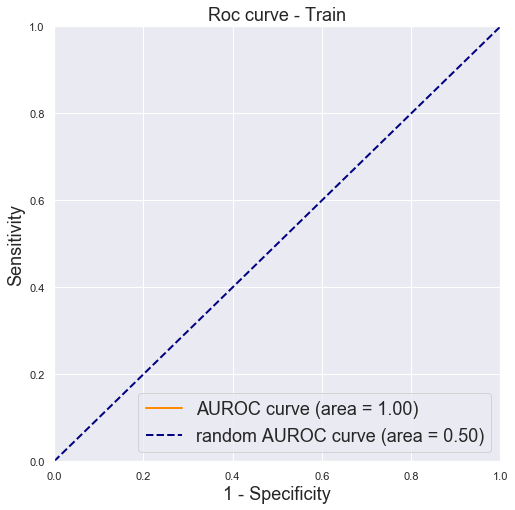

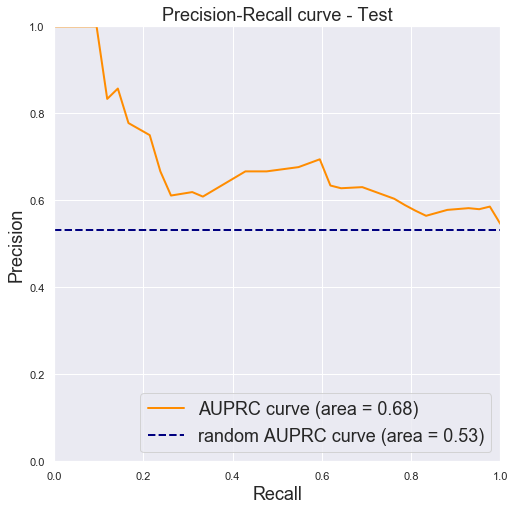

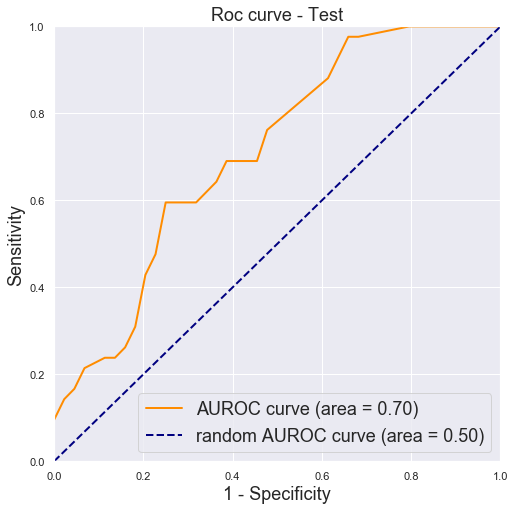

In [61]:
rf = RandomForestClassifier(n_estimators=50, random_state=seed)
rf.fit(pca_train_draft_data, train_target)

train_probs = rf.predict_proba(pca_train_draft_data)[:,1]
test_probs = rf.predict_proba(pca_test_draft_data)[:,1]

plot_pr_curve(train_target, train_probs, 'Train')
plot_roc_curve(train_target, train_probs, 'Train')

plot_pr_curve(test_target, test_probs, 'Test')
plot_roc_curve(test_target, test_probs, 'Test')
